In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as T
from torch import optim
import numpy as np
import random
from torch.autograd import Variable

import pdb
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image
import torch.cuda.amp as amp

In [2]:
from torchvision.datasets.cifar import CIFAR10
from torch.utils.data import Subset
from torch.utils.data import DataLoader

In [3]:
seed = 2

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [4]:
device_ids = [0, 1, 2, 3]
batch_size = len(device_ids) * 256
device = torch.device('cuda:{}'.format(device_ids[0]))

In [5]:
IMAGE_SIZE = 32
num_classes = 10

train_transform = T.Compose(
    [
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(
            (0.4914, 0.4822, 0.4465), 
            (0.2023, 0.1994, 0.2010)
        ),
    ]
)
test_transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(
            (0.4914, 0.4822, 0.4465), 
            (0.2023, 0.1994, 0.2010)
        ),
    ]
)
train_dataset = CIFAR10(
    root="./imgs/cifar10", train=True, download=True, transform=train_transform
)
test_dataset = CIFAR10(
    root="./imgs/cifar10", train=False, download=True, transform=test_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
indices = np.random.permutation(len(train_dataset))

In [9]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam

c_models = []
c_optims = []
c_dsets = []
c_dloaders = []

num_clients = 2
samples_per_client = 3000

for i in range(num_clients):
    c_model = nn.DataParallel(models.resnet34().to(device), device_ids=device_ids)
    c_optim = optim(c_model.parameters(), lr=3e-4)
    c_idx = indices[i*samples_per_client: (i+1)*samples_per_client]
    c_dset = Subset(train_dataset, c_idx)
    c_dloader = DataLoader(c_dset, batch_size=64*len(device_ids), shuffle=True)

    c_models.append(c_model)
    c_optims.append(c_optim)
    c_dsets.append(c_dset)
    c_dloaders.append(c_dloader)

## Isolated Training

In [10]:
acc_list = {}
for i in range(num_clients):
    acc_list[str(i)] = []

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/u/abhi24/matlaberp3/.torchP3/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/u/abhi24/matlaberp3/.torchP3/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1186, in _call_impl
    return forward_call(*input, **kwargs)
  File "/u/abhi24/matlaberp3/.torchP3/lib/python3.10/site-packages/torchvision/models/resnet.py", line 285, in forward
    return self._forward_impl(x)
  File "/u/abhi24/matlaberp3/.torchP3/lib/python3.10/site-packages/torchvision/models/resnet.py", line 278, in _forward_impl
    x = self.avgpool(x)
  File "/u/abhi24/matlaberp3/.torchP3/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1186, in _call_impl
    return forward_call(*input, **kwargs)
  File "/u/abhi24/matlaberp3/.torchP3/lib/python3.10/site-packages/torch/nn/modules/pooling.py", line 1183, in forward
    return F.adaptive_avg_pool2d(input, self.output_size)
  File "/u/abhi24/matlaberp3/.torchP3/lib/python3.10/site-packages/torch/nn/functional.py", line 1214, in adaptive_avg_pool2d
    return torch._C._nn.adaptive_avg_pool2d(input, _output_size)
RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.


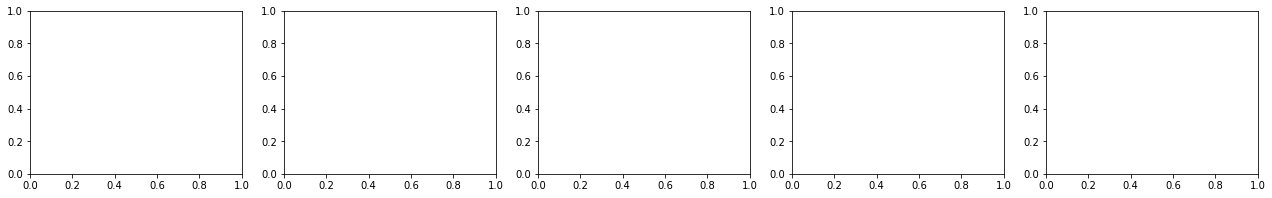

In [22]:
total_epochs = 200
fig, axs = plt.subplots(ncols=num_clients, nrows=1, figsize=(22, 3))

for epoch in range(total_epochs):
    for client_num in range(num_clients):
        c_model = c_models[client_num]
        c_model.eval()
        correct, total = 0, 0
        for x, y_hat in test_loader:
            with torch.no_grad():
                x, y_hat = x.to(device), y_hat.to(device)
                y = c_model(x)
                correct += (y.argmax(dim=1) == y_hat).sum()
                total += x.shape[0]
        acc = correct / total
        # print("epoch {}, client {}, acc {:.4f}".format(epoch, client_num, acc))
        acc_list[str(client_num)].append(acc.item())
    for client_num in range(num_clients):
        display.display(plt.gcf())
        display.clear_output(wait=True)
        axs[client_num].plot(acc_list[str(client_num)])

    for client_num in range(num_clients):
        c_model = c_models[client_num]
        c_model.train()
        c_optim = c_optims[client_num]
        c_dloader = c_dloaders[client_num]
        for x, y_hat in c_dloader:
            x, y_hat = x.to(device), y_hat.to(device)
            c_optim.zero_grad()
            y = c_model(x)
            loss = loss_fn(y, y_hat)
            loss.backward()
            c_optim.step()


## Save models

In [ ]:
for i in range(num_clients):
    torch.save(c_models[i].module.state_dict(), f"./saved_models/c{i}_isolated.pt")

## Load models

In [9]:
for i in range(num_clients):
    c_models[i].module.load_state_dict(torch.load(f"./saved_models/c{i}_isolated.pt"))

In [9]:
for i in range(num_clients):
    c_models[i].module.load_state_dict(torch.load(f"./saved_models/c{i}_collab.pt"))

## Evaluate on a common test-set

In [93]:
for client_num in range(num_clients):
    c_model = c_models[client_num]
    c_model.eval()
    correct, total = 0, 0
    for x, y_hat in test_loader:
        with torch.no_grad():
            x, y_hat = x.to(device), y_hat.to(device)
            y = c_model(x)
            correct += (y.argmax(dim=1) == y_hat).sum()
            total += x.shape[0]
    print("client {}, acc {:.4f}".format(client_num, correct/total))

client 0, acc 0.3157
client 1, acc 0.5044


## Collaborative Training

In [12]:
from modules import DeepInversionFeatureHook, total_variation_loss

In [13]:
mean=np.array((0.4914, 0.4822, 0.4465))
std=np.array((0.2023, 0.1994, 0.2010))

LOWER_IMAGE_BOUND = torch.tensor((-mean / std).reshape(1, -1, 1, 1)).float().to(device)
UPPER_IMAGE_BOUND = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1)).float().to(device)

In [125]:
def lr_policy(lr_fn):
    def _alr(optimizer, iteration, epoch):
        lr = lr_fn(iteration, epoch)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    return _alr

In [121]:
def lr_cosine_policy(base_lr, warmup_length, epochs):
    def _lr_fn(iteration, epoch):
        if epoch < warmup_length:
            lr = base_lr * (epoch + 1) / warmup_length
        else:
            e = epoch - warmup_length
            es = epochs - warmup_length
            lr = 0.5 * (1 + np.cos(np.pi * e / es)) * base_lr
        return lr

    return lr_policy(_lr_fn)

In [144]:
def run_grad_ascent_on_data(orig_img, target_label, model, lr=0.05, steps=2000):
    # print("BEFORE: memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
    # print("BEFORE: memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
    # print("BEFORE: max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

    # lr_scheduler = lr_cosine_policy(lr, 100, steps)
    alpha_ce, alpha_tv, alpha_l2, alpha_f = 100., 2.5e-5, 3e-8, 10.0
    loss_r_feature_layers = []

    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            loss_r_feature_layers.append(DeepInversionFeatureHook(module))

    updated_img = orig_img.detach()#.clone()
    updated_img.requires_grad = True
    updated_img.retain_grad()
    
    optimizer = torch.optim.Adam([updated_img], lr=lr, betas=[0.5, 0.9], eps = 1e-8)
    lim_0, lim_1 = 2, 2
    for it in range(steps):
        # lr_scheduler(optimizer, it, it)
        off1 = random.randint(-lim_0, lim_0)
        off2 = random.randint(-lim_1, lim_1)
        inputs_jit = torch.roll(updated_img, shifts=(off1, off2), dims=(2,3))

        acts = model.module(inputs_jit)[:, :10]
        ce_loss = nn.CrossEntropyLoss()(acts, target_label)
        # ce_loss = nn.MSELoss()(acts, target_label)

        loss_r_feature = sum([model.r_feature for (idx, model) in enumerate(loss_r_feature_layers)])
        loss = alpha_ce * ce_loss + alpha_tv * total_variation_loss(updated_img) + alpha_l2 * torch.linalg.norm(updated_img) + alpha_f * loss_r_feature

        if it % 50 == 0:
            acc = (acts.argmax(dim=1) == target_label.argmax(dim=1)).sum() / acts.shape[0]
            print(ce_loss.item(), loss_r_feature.item(), acc)
            # print(acts[0], target_label[0])
        loss.backward()

        # updated_img.grad.data = updated_img.grad.data / (torch.std(updated_img.grad.data) + 1e-8)
        # updated_img.data = updated_img.data - lr * grads
        optimizer.step()
        model.zero_grad()
        optimizer.zero_grad()
        updated_img.grad.data.zero_()
        updated_img.data = torch.clamp(updated_img.data, min=LOWER_IMAGE_BOUND, max=UPPER_IMAGE_BOUND)

    for item in loss_r_feature_layers:
        item.close()
    # print("FINAL max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

    # del loss_r_feature_layers, acts, grads, inputs_jit, updated_img
    # torch.cuda.empty_cache()
    # print("AFTER memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
    # print("AFTER memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
    # print("AFTER max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))
    # print(time.time() - start, "seconds")
    return updated_img

In [15]:
new_acc_list = {}
for i in range(num_clients):
    new_acc_list[str(i)] = []

In [16]:
new_acc_list

{'0': [], '1': []}

In [ ]:
bs = 256
kl_loss_fn = nn.KLDivLoss(reduction="batchmean")

fig, axs = plt.subplots(ncols=num_clients, nrows=1, figsize=(22, 3))

for epoch in range(500):
    collab_data = []
    # Evaluate on the common test set
    for client_num in range(num_clients):
        c_model = c_models[client_num]
        c_model.eval()
        correct, total = 0, 0
        for x, y_hat in test_loader:
            with torch.no_grad():
                x, y_hat = x.to(device), y_hat.to(device)
                y = c_model(x)
                correct += (y.argmax(dim=1) == y_hat).sum()
                total += x.shape[0]
        acc = correct / total
        new_acc_list[str(client_num)].append(acc.item())
    print(new_acc_list)

    # Generate collab data
    for client_num in range(num_clients):
        """ We generate a zero vector of n (num_classes dimension)
        then we generate random numbers within range n and substitute
        zero at every index obtained from random number to be 1
        This way the zero vector becomes a random one-hot vector
        """
        zeroes = torch.zeros(bs, 10)
        ind = torch.randint(low=0, high=10, size=(bs,))
        zeroes[torch.arange(start=0, end=bs), ind] = 1
        target = zeroes.to(device)
        rand_imgs = torch.randn((bs, 3, 32, 32)).to(device)

        c_model = c_models[client_num]
        c_model.eval()
        print(f"generating image for client {client_num}")
        updated_imgs = run_grad_ascent_on_data(rand_imgs, target, c_model)
        with torch.no_grad():
            acts = c_model(updated_imgs)[:, :10].detach()
        collab_data.append((updated_imgs, acts))

    # Train each client on their own data and collab data
    for client_num in range(num_clients):
        c_model = c_models[client_num]
        c_model.train()
        c_optim = c_optims[client_num]
        c_dloader = c_dloaders[client_num]
        # Train it 10 times on the same distilled dataset
        for _ in range(10):
            for c_num, (x, y_hat) in enumerate(collab_data):
                if c_num == client_num:
                    # no need to train on its own distilled data
                    continue
                x, y_hat = x.to(device), y_hat.to(device)
                c_optim.zero_grad()
                y = c_model(x)[:, :10]
                y = nn.functional.log_softmax(y, dim=1)
                loss = kl_loss_fn(y, nn.functional.softmax(y_hat, dim=1))
                loss.backward()
                c_optim.step()
        for x, y_hat in c_dloader:
            x, y_hat = x.to(device), y_hat.to(device)
            c_optim.zero_grad()
            y = c_model(x)
            loss = loss_fn(y, y_hat)
            loss.backward()
            c_optim.step()
    print("training over")
    # del collab_data, updated_imgs, acts


{'0': [0.0, 0.0, 0.0], '1': [0.0, 0.0, 0.0]}
generating image for client 0
generating image for client 1
training over
{'0': [0.0, 0.0, 0.0, 0.1964999884366989], '1': [0.0, 0.0, 0.0, 0.2214999943971634]}
generating image for client 0
generating image for client 1
training over
{'0': [0.0, 0.0, 0.0, 0.1964999884366989, 0.23339998722076416], '1': [0.0, 0.0, 0.0, 0.2214999943971634, 0.24069999158382416]}
generating image for client 0
generating image for client 1
training over
{'0': [0.0, 0.0, 0.0, 0.1964999884366989, 0.23339998722076416, 0.2378999888896942], '1': [0.0, 0.0, 0.0, 0.2214999943971634, 0.24069999158382416, 0.3157999813556671]}
generating image for client 0
generating image for client 1
training over
{'0': [0.0, 0.0, 0.0, 0.1964999884366989, 0.23339998722076416, 0.2378999888896942, 0.2962000072002411], '1': [0.0, 0.0, 0.0, 0.2214999943971634, 0.24069999158382416, 0.3157999813556671, 0.2979999780654907]}
generating image for client 0
generating image for client 1
training over

### Test for multi-gpu speedup

In [145]:
c_models[0].module.load_state_dict(torch.load("./expt_dump/non_iid_clients_collab_cifar10_2clients_5000samples_0_distill_epochs_10_steps_2000_class_per_client_2_seed1/saved_models/c0.pt"))

<All keys matched successfully>

In [146]:
rand_imgs = torch.randn((bs, 3, 32, 32))
zeroes = torch.zeros(bs, 10)

ind = torch.randint(low=0, high=1, size=(bs,))
ind += 4
zeroes[torch.arange(start=0, end=bs), ind] = 1
updated_imgs = run_grad_ascent_on_data(rand_imgs.to(device), zeroes.to(device), c_models[1], steps=4000)

1.1077171564102173 1431.0242919921875 tensor(0.3477, device='cuda:0')
1.1774671077728271 500.25689697265625 tensor(0.5312, device='cuda:0')
1.1376676559448242 485.7866516113281 tensor(0.5664, device='cuda:0')
1.0651121139526367 768.046142578125 tensor(0.5781, device='cuda:0')
1.0923118591308594 670.6159057617188 tensor(0.5859, device='cuda:0')
1.099945068359375 356.5567626953125 tensor(0.5781, device='cuda:0')
1.1142866611480713 466.1554870605469 tensor(0.5625, device='cuda:0')
1.0620708465576172 349.0640869140625 tensor(0.5938, device='cuda:0')
1.2022405862808228 464.3469543457031 tensor(0.5273, device='cuda:0')
1.0995948314666748 294.249267578125 tensor(0.5938, device='cuda:0')
1.1632664203643799 331.96612548828125 tensor(0.5430, device='cuda:0')
1.08351731300354 666.7347412109375 tensor(0.6016, device='cuda:0')
1.180774450302124 396.41265869140625 tensor(0.5508, device='cuda:0')
1.2001466751098633 365.9836730957031 tensor(0.5547, device='cuda:0')
1.152671456336975 349.62847900390625

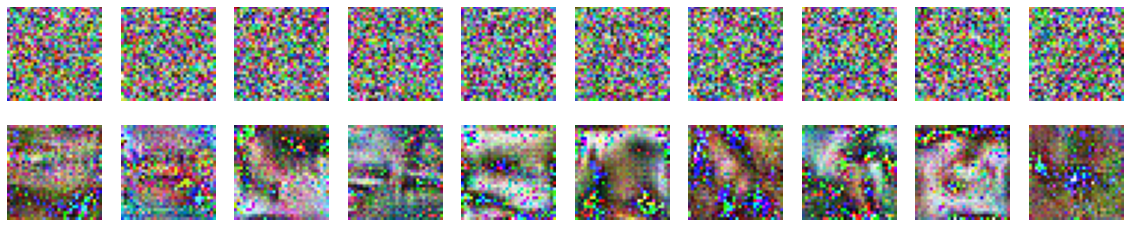

In [148]:
fig, axs = plt.subplots(ncols=10, nrows=2, figsize=(20, 4))
for i in range(10):
    axs[0][i].axis("off")
    axs[1][i].axis("off")
    axs[0][i].imshow(np.array((rand_imgs[i].detach()*255).permute(1, 2, 0).cpu()).astype(np.uint8))
    axs[1][i].imshow(deprocess(updated_imgs)[i].permute(1, 2, 0).detach().cpu())

In [83]:
# Normalize an image
def deprocess(img):
    inv_normalize = T.Normalize(
       mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
       std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_normalize(img)
    img = 255*img
    return img.type(torch.uint8)

In [84]:
c_models[0](updated_imgs).argmax(dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [85]:
zeroes.argmax(dim=1)

tensor([0, 5, 0, 0, 5, 0, 0, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 5, 0, 5, 5, 5, 5,
        5, 0, 5, 0, 0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 0, 5, 0, 5,
        5, 5, 0, 5, 5, 0, 5, 5, 5, 5, 5, 5, 0, 0, 0, 5, 5, 0, 5, 5, 0, 5, 5, 5,
        0, 0, 0, 5, 5, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 5,
        0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 0, 5, 5, 5, 0,
        0, 5, 0, 5, 0, 0, 0, 5, 5, 0, 5, 0, 5, 5, 0, 0, 0, 0, 5, 5, 0, 5, 0, 0,
        0, 5, 5, 5, 5, 0, 0, 5, 5, 0, 0, 5, 5, 5, 5, 0, 0, 5, 0, 0, 0, 0, 0, 5,
        5, 0, 5, 0, 5, 5, 5, 5, 0, 5, 5, 0, 5, 5, 5, 0, 5, 0, 5, 0, 5, 5, 0, 5,
        5, 5, 0, 0, 0, 5, 5, 0, 5, 5, 0, 5, 0, 5, 0, 5, 5, 0, 5, 0, 0, 0, 0, 0,
        0, 5, 0, 5, 0, 5, 5, 5, 0, 0, 0, 5, 0, 5, 5, 5, 5, 0, 0, 5, 0, 5, 0, 5,
        5, 0, 0, 0, 0, 5, 0, 5, 0, 5, 0, 0, 0, 0, 0, 5])

In [56]:
c_models[0].eval()
correct, total = 0, 0
for x, y_hat in test_loader:
    with torch.no_grad():
        x, y_hat = x.to(device), y_hat.to(device)
        y = c_models[0](x)
        correct += (y.argmax(dim=1) == y_hat).sum()
        total += x.shape[0]
        print(y.argmax(dim=1), y_hat)
print("client {}, acc {:.4f}".format(client_num, correct/total))

tensor([5, 0, 0,  ..., 0, 0, 0], device='cuda:0') tensor([3, 8, 8,  ..., 1, 0, 0], device='cuda:0')
tensor([5, 5, 0,  ..., 0, 5, 5], device='cuda:0') tensor([3, 5, 0,  ..., 1, 3, 5], device='cuda:0')
tensor([0, 5, 0,  ..., 0, 0, 5], device='cuda:0') tensor([8, 3, 8,  ..., 4, 0, 7], device='cuda:0')
tensor([0, 5, 0,  ..., 5, 5, 0], device='cuda:0') tensor([8, 3, 1,  ..., 3, 3, 8], device='cuda:0')
tensor([0, 5, 0,  ..., 5, 0, 5], device='cuda:0') tensor([8, 3, 9,  ..., 7, 2, 5], device='cuda:0')
tensor([0, 5, 5,  ..., 0, 5, 5], device='cuda:0') tensor([9, 6, 6,  ..., 8, 5, 9], device='cuda:0')
tensor([5, 5, 0,  ..., 0, 5, 5], device='cuda:0') tensor([7, 2, 0,  ..., 0, 1, 7], device='cuda:0')
tensor([5, 0, 0,  ..., 0, 5, 5], device='cuda:0') tensor([5, 1, 9,  ..., 8, 4, 6], device='cuda:0')
tensor([5, 5, 0,  ..., 5, 5, 5], device='cuda:0') tensor([5, 3, 1,  ..., 2, 9, 5], device='cuda:0')
tensor([5, 0, 5, 5, 0, 5, 0, 5, 5, 0, 5, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 5, 5, 5, 